<img src="NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing <b> </font>

<font size="5"> <b>Lab 7: Deep Learning in Earth Observation: Demo Exercise </b> </font>

<br>
<font size="4"> <b> Lichao Mou, German Aerospace Center; Xiaoxiang Zhu, German Aerospace Center & Technical University Munich </b> <br>
</font>

<img src="NotebookAddons/dlr-logo-png-transparent.png" width="170" align="right" border="2"/> <font size="3"> This Lab introduces you to the basic concepts of Deep Learning in Earth Observation. Specifically, it uses the simple example of learning the temporal pattern of a cosine curve to demonstrate the concepts of Recurrent Neural Networks (RNNs). The lab let's you experiment with several hyper-parameters needed for training Deep Learning Networks such as RNNs, CNNs, or similar.
    
We will again use a **Jupyter Notebook** framework implemented within the Amazon Web Services (AWS) cloud to work on this exercise. This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. It will introduce the following data analysis concepts:

- How to set up a recurrent deep network within the Python-based <i>keras/tensorflow</i> environment
- How to create an LSTM (long-term/short-term memory) recurrent network 
- How to optimize hyper-parameters when training a deep neural network
</font>

<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>There are no Homework assignments associated with this Notebook </b> </font>
</font>
<br>
<hr>

<font face="Calibri" size="5" color="red"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>
<hr>

# Predict a cosine wave using RNNs

* A simple tutorial on LSTM and GRU to perdict a trigonometric wave.

* Data noise can be added to test the robustness of the model.

* Hyperparamters of the RNNs can be tweaked


<hr>
<font face="Calibri" size="4"> <b>0. Importing Relevant Python Packages </b> </font>

<font size="3">Our first step is to <b>import the necessary python libraries into your Jupyter Notebook.</b></font>

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, GRU, TimeDistributed
from keras.optimizers import RMSprop

from asf_notebook import new_directory

Using TensorFlow backend.


<hr>
<font face="Calibri" size="4"><b>1. Create a working directory for the analysis and change into it:</b></font>

In [2]:
base_path = "/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_7_cosine"
new_directory(base_path)
os.chdir(base_path)
print(f"Current working directory: {os.getcwd()}")

/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_7_cosine already exists.
Current working directory: /home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_7_cosine


<hr>
<font face="Calibri" size="4"><b>2. Get cosine data</b></font>
<br><br>
<font face="Calibri" size="3">Data to train and evaluate the RNN:</font>

- Start, end and step define the range of the data series.
- Sequence length defines the series to look back to train the model
- Noisy data can be added to make the training data imperfect.

<br>
<font face="Calibri" size="3"><b>Write a function to define training data:</b></font>

In [3]:
# Takes: starting point, end point, number of steps between points
# number of steps to backpropagate through time, and noise to create imperfect data
# Returns: X,Y data


def cosine_data(start, end, step, sequence_length, noise_level=0):

    t = np.arange(start, end, step)
    cosine = np.cos(2 * np.pi * t) + noise_level * \
        np.random.normal(0, 1, np.shape(t))
    cosine = cosine.reshape((cosine.shape[0], 1))

    dX, dY = [], []
    for i in range(len(cosine) - 2*sequence_length):
        dX.append(cosine[i:i + sequence_length])
        dY.append(cosine[i + sequence_length:i + 2*sequence_length])
    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY


<hr>
<font face="Calibri" size="4"><b>3. Create an LSTM model</b></font>

- Linear activation
- Loss in mean squared error

<font face="Calibri" size="3"><b> Write a function that creates an LSTM model:</b></font>

In [4]:
# Takes: number of neurons to train a GRU network, number of features to predict, and learning_rate
# Returns: model for training


def LSTM_(hidden_neurons, feature_count, learning_rate):
    model = Sequential()
    model.add(LSTM(input_dim=feature_count,
                   output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))
    optimizer = RMSprop(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mse'])
    return model


<hr>
<font face="Calibri" size="4"><b>3. Create a GRU model</b></font>

- Linear activation
- Get loss using a mean squared error

<font face="Calibri" size="3"><b>Write a function that creates a GRU model:</b></font>

In [5]:
# Takes number of neurons to train a GRU network, number of features to predict, and learning_rate
# Returns: model for training


def GRU_(hidden_neurons, feature_count, learning_rate):
    model = Sequential()
    model.add(GRU(input_dim=feature_count,
                  output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))
    optimizer = RMSprop(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mse'])
    return model

<hr>
<font face="Calibri" size="4"><b>4. Write a function to train an RNN model:</b></font>

In [6]:
# Takes: load RNN model, X cosine train data, Y cosine train data,
# number of samples to be propagated through the network, and
# number of time dataset is processed
# Returns: training and validation loss


def train_cosine(model, dataX, dataY, batch_size, epoch_count, count):

    history = model.fit(dataX, dataY, batch_size=batch_size,
                        epochs=epoch_count, validation_split=0.05)
    loss_history = history.history['loss']
    loss_history = np.array(loss_history)
    #np.savetxt("loss_history.txt", numpy_loss_history, delimiter=",")
    val_loss_history = history.history['val_loss']
    val_loss_history = np.array(val_loss_history)
    #np.savetxt("val_loss_history.txt", numpy_loss_history, delimiter=",")
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(loss)
    plt.plot(loss_val)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(f"{os.getcwd()}/loss_{count}.png", dpi=72)
    plt.show()

    return loss_history, val_loss_history

<hr>
<font face="Calibri" size="4"><b>5. Write a function to run an RNN model:</b></font>

In [7]:
# Takes: number of Epochs, noise level in training data, sequence length available to train a RNN,
# learning_rate, batch_size, nb_units, boolean if results should be plotted
# Return: Loss and Plot


def test_cosine(EPOCHS, count, noise_level=0.3, sequence_length=100, learning_rate=1e-3, batch_size=16, nb_units=32, plot_results=False):

    dataX, dataY = cosine_data(
        0.0, 10, 0.02, sequence_length, noise_level)  # 4.0
    # create and fit the LSTM network
    print('creating model...')

    # Choose RNN to train
    model = LSTM_(nb_units, 1, learning_rate)
    #model = GRU_(nb_units, 1, learning_rate)

    # Train RNN model
    tr_loss, val_loss = train_cosine(model, dataX, dataY, batch_size, EPOCHS, count)

    # now test
    dataX1, dataY1 = cosine_data(15.0, 21.0, 0.02, sequence_length)
    predict = model.predict(dataX1)
    if plot_results:
        plot_RNN_results(dataX, dataX1, dataY1, predict, sequence_length, count)

    return tr_loss, val_loss

<hr>
<font face="Calibri" size="4"><b>6. Write a function to plot RNN results:</b></font>

In [8]:
def plot_RNN_results(dataX, dataX1, dataY1, predict, sequence_length, count):
    nan_array = np.empty((sequence_length - 1))
    nan_array.fill(np.nan)
    nan_array2 = np.empty(sequence_length)
    nan_array2.fill(np.nan)
    ind = np.arange(2*sequence_length)
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(1, 1, 1)
    forecasts = np.concatenate(
        (nan_array, dataX1[0, -1:, 0], predict[0, :, 0]))
    ground_truth = np.concatenate(
        (nan_array, dataX1[0, -1:, 0], dataY1[0, :, 0]))
    network_input = np.concatenate((dataX[0, :, 0], nan_array2))

    ax.plot(ind, network_input, 'b-x', label='Network input')
    ax.plot(ind, forecasts, 'r-x', label='Many to many model forecast')
    ax.plot(ind, ground_truth, 'g-x', label='Ground truth')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('t')
    plt.ylabel('cos(t)')
    plt.title('Cosine Many to Many Forecast')
    text = ax.text(-0.2,1.05, " ", transform=ax.transAxes) #this is dummy text, needed by bbox_inches='tight', which requires >1 artist 
    lgd = ax.legend(handles, labels, bbox_to_anchor=(0.5, -0.1), loc='upper center')
    plt.savefig(f"{os.getcwd()}/cosine_wave_{count}.png", dpi=72, bbox_extra_artists=(lgd, text), bbox_inches='tight')
    plt.show()

<hr>
<font face="Calibri" size="4"><b>7. Write functions to group and save the plots created by train_cosine() and plot_RNN_results():</b></font>
<br><br>
<font face="Calibri" size="3"><b>Write a function to group the paths to the plots that will be concatenated:</b></font>

In [9]:
def group_plot_paths(count):
    paths = []
    for i in range (0, count):
        paths.append(glob.glob(f"*_{i}.*"))
    for i in range (0, len(paths)):
        paths[i].sort()
    return paths

<font face="Calibri" size="3"><b>Write a function to concatenate and save the plots:</b></font>

In [10]:
def concat_plots(count):
    plot_pairs = group_plot_paths(count)
    for i in range(0, len(plot_pairs)):
        images = list(map(Image.open, plot_pairs[i]))
        widths, heights = zip(*(x.size for x in images))
        total_width = sum(widths)
        max_height = max(heights)
        x_offset = 0
        new_image = Image.new('RGBA', (total_width, max_height))
        for im in images:
            new_image.paste(im, (x_offset, 0))
            x_offset += im.size[0]
        new_image.save(f"cosine_wave_loss_{i}.png", "png")
    delete_files(plot_pairs)

<font face="Calibri" size="3"><b>Write a function to delete the original seperate image files after they have been concatenated:</b></font>

In [11]:
def delete_files(files_list):
    assert type(files_list) == list
    assert type(files_list[0]) == list
    for files in files_list:
        for file in files:
            try:
                os.remove(file)
            except:
                FileNotFoundError

<font face="Calibri" size="4"><b>8. Train and run the RNN model:</b></font>

creating model...
Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=32)`
  


Instructions for updating:
Use tf.cast instead.
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 1s 5ms/step - loss: 3.5158 - mean_squared_error: 3.5158 - val_loss: 1.2800 - val_mean_squared_error: 1.2800
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.6476 - mean_squared_error: 0.6476 - val_loss: 0.2281 - val_mean_squared_error: 0.2281
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2129 - mean_squared_error: 0.2129 - val_loss: 0.1823 - val_mean_squared_error: 0.1823
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1671 - mean_squared_error: 0.1671 - val_loss: 0.1544 - val_mean_squared_error: 0.1544
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1735 - mean_squared_error: 0.1735 - val_loss: 0.1874 - val_mean_squared_error: 0.1874
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1582 - mean_squared_e

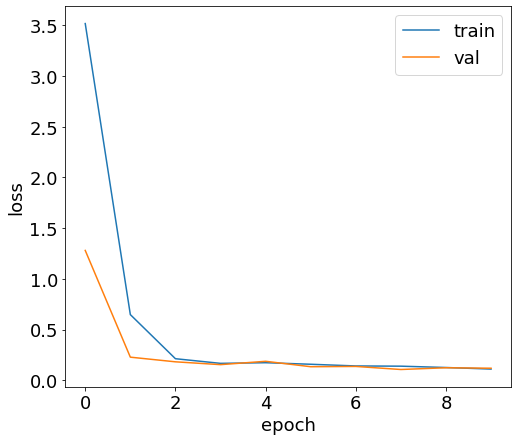

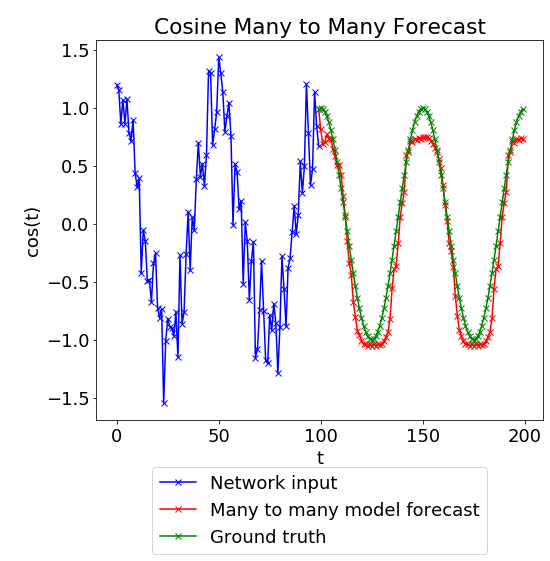

tr_loss: [3.51579595 0.64762741 0.21293218 0.16706828 0.17346456 0.15823622
 0.14151767 0.13929765 0.12623214 0.11083975]
val_loss: [1.27997625 0.22813673 0.18225084 0.15443112 0.18741459 0.13400106
 0.13675362 0.10651795 0.12376664 0.11911793]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.1685 - mean_squared_error: 0.1685 - val_loss: 0.1360 - val_mean_squared_error: 0.1360
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1403 - val_mean_squared_error: 0.1403
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1116 - val_mean_squared_error: 0.1116
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1182 - mean_squared_error: 0.1182 - val_loss: 0.1172 - val_mean_squared_error: 0.1172
Epoch 5/10
285/285 [========================

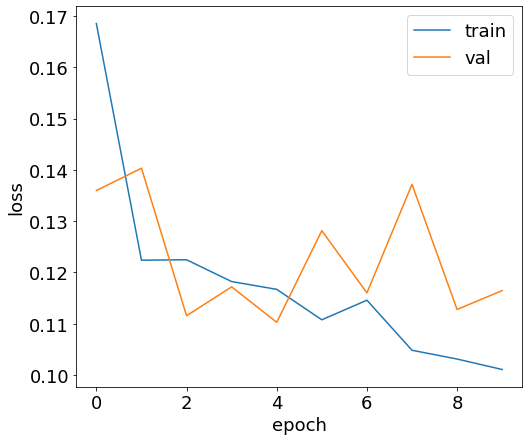

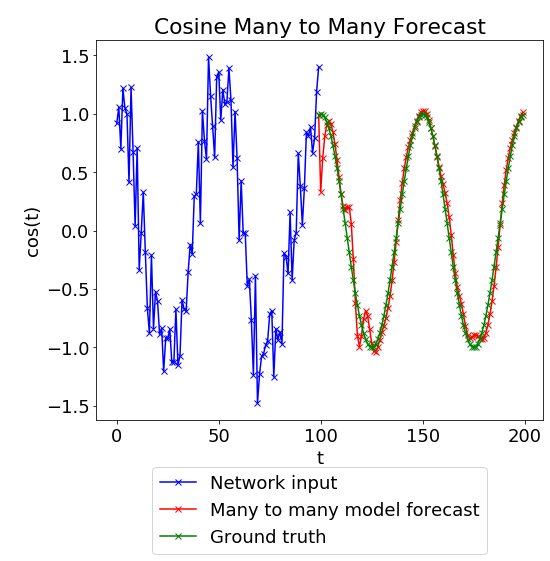

tr_loss: [0.16850395 0.1223927  0.12247892 0.11823101 0.11671395 0.11077847
 0.1145996  0.10484097 0.1031314  0.10109181]
val_loss: [0.1359649  0.14031769 0.11156988 0.11719615 0.11028914 0.1281479
 0.11601727 0.13718271 0.11279199 0.11647297]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.3375 - mean_squared_error: 0.3375 - val_loss: 0.2310 - val_mean_squared_error: 0.2310
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1576 - mean_squared_error: 0.1576 - val_loss: 0.1587 - val_mean_squared_error: 0.1587
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1546 - val_mean_squared_error: 0.1546
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1533 - val_mean_squared_error: 0.1533
Epoch 5/10
285/285 [=========================

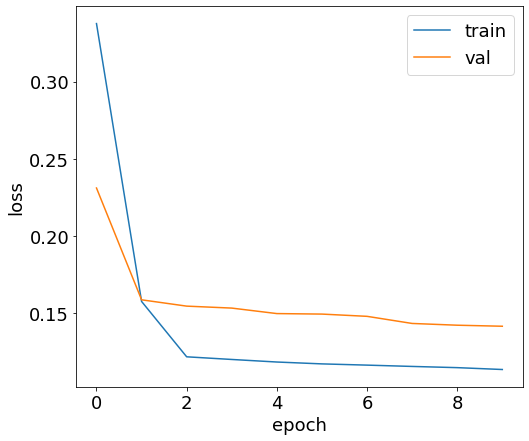

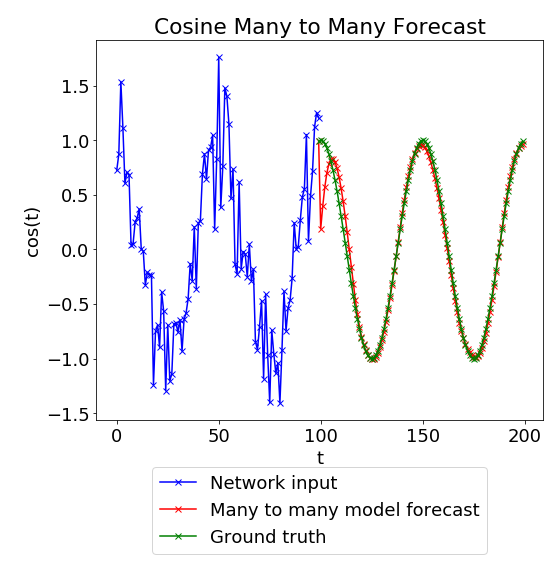

tr_loss: [0.33751745 0.15759703 0.12174868 0.1200277  0.11837293 0.11716312
 0.11636286 0.11551575 0.11473288 0.11352717]
val_loss: [0.23104499 0.15865085 0.15456183 0.15329139 0.14973818 0.14940916
 0.14795282 0.1433472  0.14220832 0.14153974]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.6580 - mean_squared_error: 0.6580 - val_loss: 0.6674 - val_mean_squared_error: 0.6674
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.6156 - mean_squared_error: 0.6156 - val_loss: 0.6305 - val_mean_squared_error: 0.6305
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.5806 - mean_squared_error: 0.5806 - val_loss: 0.5966 - val_mean_squared_error: 0.5966
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.5479 - mean_squared_error: 0.5479 - val_loss: 0.5647 - val_mean_squared_error: 0.5647
Epoch 5/10
285/285 [========================

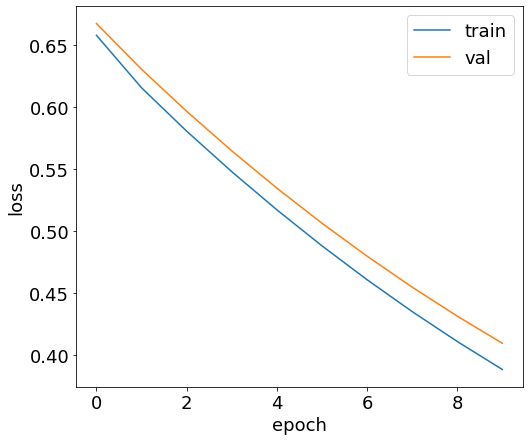

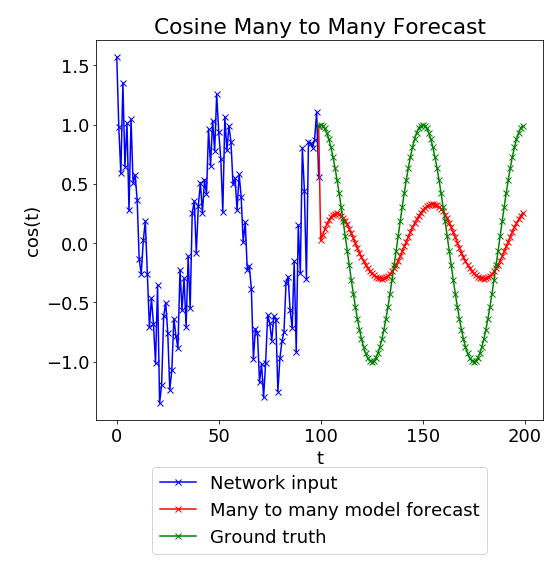

tr_loss: [0.65796571 0.6155969  0.58060343 0.54793822 0.51714052 0.48809771
 0.4607539  0.43503694 0.41090931 0.38827021]
val_loss: [0.66744578 0.63049996 0.59663785 0.56470948 0.53464276 0.50633985
 0.47975445 0.45475975 0.43134797 0.4094384 ]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.5742 - mean_squared_error: 0.5742 - val_loss: 0.5956 - val_mean_squared_error: 0.5956
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.5703 - mean_squared_error: 0.5703 - val_loss: 0.5917 - val_mean_squared_error: 0.5917
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.5669 - mean_squared_error: 0.5669 - val_loss: 0.5879 - val_mean_squared_error: 0.5879
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.5635 - mean_squared_error: 0.5635 - val_loss: 0.5842 - val_mean_squared_error: 0.5841
Epoch 5/10
285/285 [========================

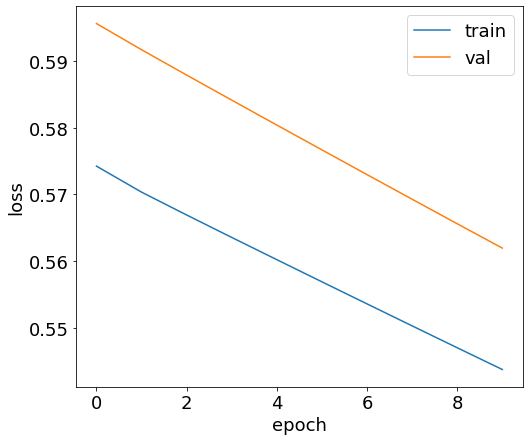

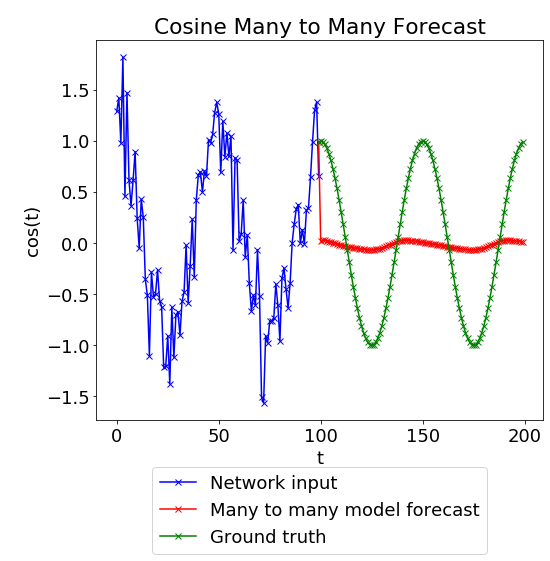

tr_loss: [0.57424426 0.57034169 0.56691406 0.5635452  0.56020575 0.55688168
 0.55357134 0.55027332 0.54699004 0.54372436]
val_loss: [0.59564185 0.59171468 0.58791298 0.58415002 0.58040792 0.57668674
 0.57297307 0.5692786  0.5655992  0.56194359]


"\n# hyperparameter: 4) nb_units\nnb_units_range = [8, 16, 32, 64, 128]\nfor nu in nb_units_range:\n    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, nb_units=nu, plot_results=True)\n    print('tr_loss:', tr_loss)\n    print('val_loss:', val_loss)\n"

In [12]:
nb_epochs = 10
noise_level = 0.0
sequence_length = 100
'''
learning_rate = 1e-3  # 1e-1, 1e-2, 1e-3, 1e-4, 1e-5
batch_size = 16  # 1, 2, 4, 8, 16
nb_units = 32  # 8, 16, 32, 64, 128

_, _ = test_cosine(EPOCHS = nb_epochs, noise_level =noise_level, 
                   plot_results=True)
'''
# try with different noise
'''
noise_level_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for nl in noise_level_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, noise_level=nl)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''

# hyperparameter: 1) lr
learning_rate_range = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
count = 0
for lr in learning_rate_range:
    tr_loss, val_loss = test_cosine(nb_epochs, count, learning_rate=lr, plot_results=True)
    count += 1
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
concat_plots(len(learning_rate_range))

'''
# hyperparameter: 2) batch size
batch_size_range = [2, 4, 8, 16, 32]
for bs in batch_size_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, batch_size=bs, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''
'''
# hyperparameter: 3) sequence length
sequence_length_range = [20, 50, 100, 200, 500]
for sl in sequence_length_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, sequence_length=sl, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''
'''
# hyperparameter: 4) nb_units
nb_units_range = [8, 16, 32, 64, 128]
for nu in nb_units_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, nb_units=nu, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''
